# Information Retrieval

In [2]:
import ParserCACM
import TextRepresenter
import indexation
import modeles
from query import QueryParserCACM
import evaluation
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import operator

%load_ext autoreload

""" Some info to remember when testing:
- Query 10 is about parallel computation
- Doc 46 is about parallelism too
"""

# Constants:
srcFolder = "cacm"
srcFile = "cacm.txt"
qryFile = "cacm.qry"
relFile = "cacm.rel"
gendata = "gendata"
indexName = "cacm"
docId = 46
queryId = np.random.randint(1,60)
wordTest = "logic"

cacm_txt = os.path.join(srcFolder, srcFile)
cacm_qry = os.path.join(srcFolder, qryFile)
cacm_rel = os.path.join(srcFolder, relFile)

## Testing the indexation:

In [3]:
# Construct the index:
idx = indexation.Index(indexName, gendata)
stemmer = TextRepresenter.PorterStemmer()
idx.indexation(cacm_txt, ParserCACM.ParserCACM(),
               stemmer)

Performing the indexation...
1st pass: build the index...
2nd pass: build the inverted index...
Finished.


In [4]:
print("\n###### Testing the index: ###### ")
print("Retrieve common stems in doc %d:" % docId)
stems = sorted(idx.getTfsForDoc(docId).items(), key=operator.itemgetter(1), reverse=True)
print([stem for stem, freq in stems[:10]])
print("""Should look like
> “The tendency towards increased parallelism in
> computers is noted.  Exploitation of this parallelism
> presents a number of new problems in machine design
> and in programming systems...”""")

print("\nRetrieve docs that contains 'logic'")
docs = idx.getTfsForStem("logic") 
print("Should include doc 63 and 46:", (63 in docs.keys() and 46 in docs.keys()))


###### Testing the index: ###### 
Retrieve common stems in doc 46:
['program', 'programm', 'problem', 'parallel', 'requir', 'stretch', 'logic', 'exploit', 'concurr', 'burden']
Should look like
> “The tendency towards increased parallelism in
> computers is noted.  Exploitation of this parallelism
> presents a number of new problems in machine design
> and in programming systems...”

Retrieve docs that contains 'logic'
Should include doc 63 and 46: True


## Testing the weighters:

In [5]:
print("\n###### Testing BinaryWeighter: ###### ")
query = stemmer.getTextRepresentation(" Parallel languages; languages for parallel computation")

# bw = modeles.BinaryWeighter(idx)
# print("bw.getDocWeightsForDoc(",docId,"):", 
#     bw.getDocWeightsForDoc(docId))
# print("\nbw.getDocWeightsForStem('"+wordTest+"'):", 
#     bw.getDocWeightsForStem(wordTest))
# print("\nbw.getWeightsForQuery(' Parallel languages; languages for parallel computation'):", 
#     bw.getWeightsForQuery(query))

# print("\n###### Testing Vectoriel with BinaryWeighter: ###### ")
# vect = modeles.Vectoriel(idx, bw)
# print("Top 10 documents for the previous query:")
# print(vect.getRanking(query)[:10])


###### Testing BinaryWeighter: ###### 


In [6]:

print("\n###### Testing TfidfWeighter: ###### ")
tfidfWeighter = modeles.TfidfWeighter(idx)
vect = modeles.Vectoriel(idx, tfidfWeighter)

# print("tfidfWeighter.getDocWeightsForDoc(", docId, "):",
#     tfidfWeighter.getDocWeightsForDoc(docId))
# print("\ntfidfWeighter.getDocWeightsForStem(\"logic\"):",
#     tfidfWeighter.getDocWeightsForStem(wordTest))
# print("\ntfidfWeighter.getWeightsForQuery(query):",
#     tfidfWeighter.getWeightsForQuery(query))

# print("\n###### Testing Vectoriel with TfidfWeighter: ###### ")
# print("Top 10 documents for the query:")
# print(vect.getRanking(query)[:10])



###### Testing TfidfWeighter: ###### 


## Testing the QueryParser

In [7]:
# print("\n###### Testing QueryParserCACM: ###### ")
# qp = QueryParserCACM(cacm_qry, cacm_rel)
# query = qp.nextQuery()
# print("Searching for query #%d:" % queryId)
# while query is not None and query.getID() != str(queryId):
#     print(query)
#     print(20*'-')
#     query = qp.nextQuery()
    
# print("Query:", query)
# queryTxt = stemmer.getTextRepresentation(query.getText())
# scores = vect.getRanking(queryTxt)
# print("\nScores:", scores[:10])


## Testing measures:



###### Testing evaluation.PrecisionRecallMeasure: ###### 
Searching for query # [7, 10, 14, 25, 26, 27, 42, 43]
Query: Query {id=7, txt='I am interested in distributed algorithms - concurrent programs in
which processes communicate and synchronize by using message passing.
Areas of particular interest include fault-tolerance and techniques
for understanding the correctness of these algorithms.
', relevances=[3141, 2376, 3148, 3082, 2700, 2895, 2320, 2578, 1877, 2777, 2618, 2597, 2912, 2256, 3043, 2342, 2150, 2280, 2866, 1198, 2941, 2865, 2482, 1960, 2228, 3128, 1338, 2685]}
Retrieve scores...
Evaluate the scores.


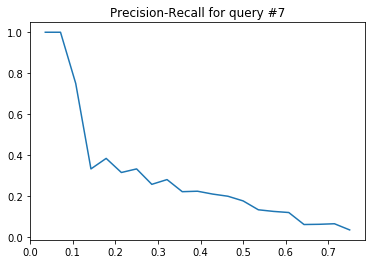

Query: Query {id=10, txt='Parallel languages; languages for parallel computation
', relevances=[2896, 1601, 1795, 3075, 1158, 2433, 2376, 2700, 2060, 1613, 141, 2256, 1747, 3156, 1262, 2777, 2714, 2895, 3039, 2912, 2785, 2851, 1380, 2342, 2150, 2289, 2664, 46, 1198, 392, 1811, 950, 2618, 2685, 1471]}
Retrieve scores...
Evaluate the scores.


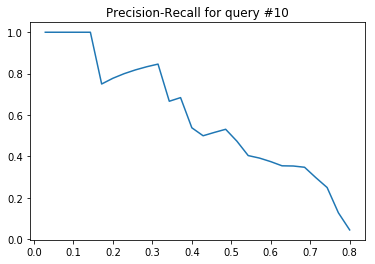

Query: Query {id=14, txt='find all discussions of optimal implementations of sort algorithms for
database management applications
', relevances=[2176, 2563, 776, 2191, 3075, 1175, 2714, 2716, 866, 2337, 1956, 2348, 2397, 1969, 827, 2108, 864, 1724, 2118, 865, 74, 1997, 850, 851, 852, 854, 855, 856, 857, 858, 860, 861, 862, 2272, 2017, 2146, 2664, 1980, 232, 3187, 117, 2679, 2041, 1919]}
Retrieve scores...
Evaluate the scores.


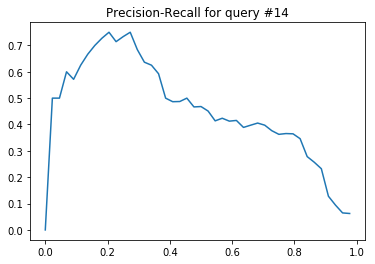

Query: Query {id=25, txt='Performance evaluation and modelling of computer systems
', relevances=[1408, 2434, 1901, 268, 1805, 2318, 2319, 3088, 3089, 2452, 1518, 2582, 2818, 2095, 1698, 1572, 2085, 2984, 2218, 2859, 2988, 2862, 2863, 2996, 2741, 2358, 1719, 3006, 1653, 2881, 963, 2373, 2765, 2831, 1892, 2277, 2918, 2535, 3048, 3119, 2667, 2668, 2669, 2798, 2928, 3059, 757, 1526, 2681, 3067, 1533]}
Retrieve scores...
Evaluate the scores.


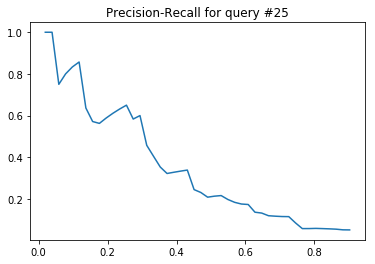

Query: Query {id=26, txt='Concurrency control mechanisms in operating systems
', relevances=[2912, 2376, 3082, 2379, 2700, 2320, 3043, 1749, 2777, 2618, 2597, 2080, 2256, 2851, 1828, 2150, 2342, 1960, 3048, 2541, 1198, 1071, 2632, 2866, 2740, 2938, 3128, 1338, 3039, 1854]}
Retrieve scores...
Evaluate the scores.


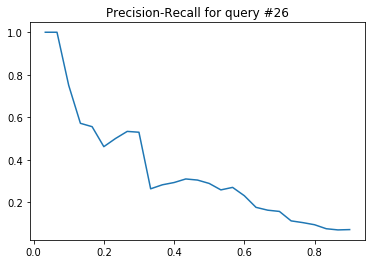

Query: Query {id=27, txt='Memory management aspects of operating systems
', relevances=[2560, 2498, 2435, 2902, 3052, 2955, 2818, 2669, 2768, 2798, 1750, 1879, 1752, 1884, 2596, 2918, 2983, 1641, 1642, 2859, 2988, 1901, 2734, 2095, 2864, 2481, 3000, 2297, 2747]}
Retrieve scores...
Evaluate the scores.


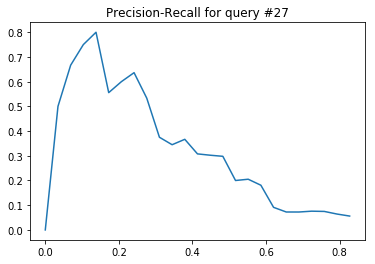

Query: Query {id=42, txt='Computer performance evaluation techniques using pattern recognition
and clustering.
', relevances=[3072, 1827, 1572, 2085, 2022, 2151, 2344, 2247, 3048, 1805, 1518, 1069, 2984, 2318, 2951, 1653, 2542, 2522, 1884, 2749]}
Retrieve scores...
Evaluate the scores.


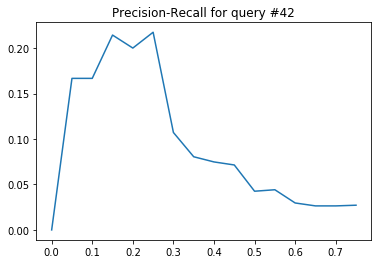

Query: Query {id=43, txt='Analysis and perception of shape by humans and computers.  Shape
descriptions, shape recognition by computer.  Two-dimensional shapes.
Measures of circularity.  Shape matching.
', relevances=[3172, 2754, 2883, 2811, 3116, 266, 2827, 2828, 2829, 462, 3149, 2514, 2195, 2004, 2382, 1686, 1113, 2201, 2523, 1554, 2910, 2655, 2400, 1697, 2211, 2788, 3047, 297, 2924, 1325, 2994, 2771, 2421, 3062, 1528, 122, 2751, 2841, 2826, 2913, 2687]}
Retrieve scores...
Evaluate the scores.


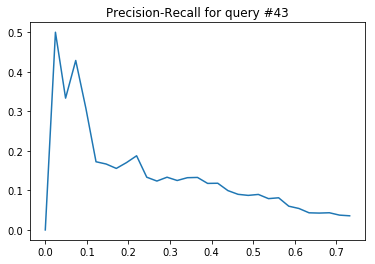

In [8]:
print("\n###### Testing evaluation.PrecisionRecallMeasure: ###### ")
queryChosen = np.random.randint(1, 50, size=10)
queryChosen =[7, 10, 14, 25, 26, 27, 42, 43] # lots of relevant results
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #",queryChosen)
while query is not None :
    if int(query.getID()) in queryChosen:
        print("Query:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        scores = vect.getRanking(queryTxt)
        irlist = evaluation.IRList(query, scores)
        precisRecall = evaluation.PrecisionRecallMeasure(irlist)
        print("Evaluate the scores.")
        pr = precisRecall.eval(verbose=False, size=100) # (recall, precision)
        precision = [p for r,p in pr]
        recall = [r for r,p in pr]
        plt.plot(recall, precision)
        plt.title("Precision-Recall for query #"+query.getID())
        plt.show()
        print(20*'-')

        
    query = qp.nextQuery()
    

In [9]:
print("\n###### Testing evaluation.AveragePrecision: ###### ")
queryChosen = np.random.randint(1, 50, size=10)
queryChosen =[7, 10, 14, 25, 26, 27, 42, 43] # lots of relevant results
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #",queryChosen)
while query is not None :
    if int(query.getID()) in queryChosen:
        print("Query:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        scores = vect.getRanking(queryTxt)
        irlist = evaluation.IRList(query, scores)
        average_measure = evaluation.AveragePrecision(irlist)
        print("Evaluate the scores.")
        average_prec = average_measure.eval(verbose=False, step=1)
        print("Average precision: %f" % average_prec)
        print(20*'-')
        
    query = qp.nextQuery()
    


###### Testing evaluation.AveragePrecision: ###### 
Searching for query # [7, 10, 14, 25, 26, 27, 42, 43]
Query: Query {id=7, txt='I am interested in distributed algorithms - concurrent programs in
which processes communicate and synchronize by using message passing.
Areas of particular interest include fault-tolerance and techniques
for understanding the correctness of these algorithms.
', relevances=[3141, 2376, 3148, 3082, 2700, 2895, 2320, 2578, 1877, 2777, 2618, 2597, 2912, 2256, 3043, 2342, 2150, 2280, 2866, 1198, 2941, 2865, 2482, 1960, 2228, 3128, 1338, 2685]}
Retrieve scores...
Evaluate the scores.
Average precision: 0.224929
--------------------
Query: Query {id=10, txt='Parallel languages; languages for parallel computation
', relevances=[2896, 1601, 1795, 3075, 1158, 2433, 2376, 2700, 2060, 1613, 141, 2256, 1747, 3156, 1262, 2777, 2714, 2895, 3039, 2912, 2785, 2851, 1380, 2342, 2150, 2289, 2664, 46, 1198, 392, 1811, 950, 2618, 2685, 1471]}
Retrieve scores...
Evaluate the s